In [1]:
!python -c "import monai" || pip install -q "monai[nibabel, tqdm ,einops]"
!python -c "import matplotlib" || pip install -q matplotlib

In [2]:
import os
import shutil
import tempfile
import time
from datetime import datetime
from tqdm import tqdm
from collections import defaultdict

import matplotlib.pyplot as plt


from colorama import Fore, Back, Style
g_ = Fore.GREEN
c_ = Fore.CYAN
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

#Optims




from models import ResNet3dVAE, ResNet3d, build_model, get_optimizer, get_scheduler
from utils import Visualizer, DatasetTransforms



from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss, GeneralizedWassersteinDiceLoss, DiceCELoss, DiceFocalLoss, TverskyLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets.attentionunet import AttentionUnet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    CropForegroundd,
    Resized,
    SpatialPadd,
    DivisiblePadd,
    RandGaussianSmoothd,
    ScaleIntensityRanged,
    RandCropByPosNegLabeld,
    RandRotated,
    RandZoomd,
    RandGaussianNoised,
    RandGaussianSharpend,
    RandAdjustContrastd,
    ToTensord,
    RandRicianNoised,
    GaussianSmoothd,
    GibbsNoised
)
from monai.utils import set_determinism

import torch
import torch.nn as nn
import numpy as np

import json
import wandb

In [3]:
directory = "/notebooks/shared/data"
root_dir = tempfile.mkdtemp() if directory is None else directory

In [4]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                torch.logical_or(
                    torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

In [5]:
train_transform= Compose([
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
        keys=["image", "label"],
        pixdim=(1.0, .77, .77),
        mode=("bilinear", "nearest"),
            ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        #CropForegroundd(
        #                keys=["image", "label"],
        #                source_key="image",
        #                k_divisible=[128,128,128],),   
        #Resized(keys=["image", "label"], spatial_size=(128, 128, 128), mode=("area", "nearest")),
        #SpatialPadd(keys=["image", "label"], spatial_size=(128, 128, 128)),

        RandGaussianNoised(keys="image", prob=1, mean= 0, std = 0.1),
        #RandRicianNoised(keys=["image" ,"label"], prob=1, mean= 1, std = 0.5),
        #GibbsNoised(keys="image",  alpha=0.8),
        #RandGaussianSmoothd(keys="image", prob=1 ,sigma_x=(0.5, 1.5)),
        #RandGaussianSharpend(keys="image", prob=1 sigma1_y=(0.5, 1.5)),
        #RandGaussianSharpend(keys="image", prob=1 ,sigma1_z=(0.5, 1.5)),
        #RandAdjustContrastd(keys="image", prob=1, gamma=(1.5, 1.5)),
        #RandRotated(keys=["image", "label"], prob=1, range_y=[0.3, 0.3], mode=["bilinear", "nearest"]),
        #RandRotated(keys=["image", "label"], prob=1, range_x=[0.3, 0.3], mode=["bilinear", "nearest"]),
        #RandRotated(keys=["image", "label"], prob=1, range_z=[0.3, 0.3], mode=["bilinear", "nearest"]),


        #NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        #RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        #RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        #RandFlipd(keys=["image", "label"], prob=1, spatial_axis=0),
        #RandFlipd(keys=["image", "label"], prob=1, spatial_axis=1),
        #RandFlipd(keys=["image", "label"], prob=1, spatial_axis=2),
        #RandZoomd(keys=["image", "label"], prob = 1,  min_zoom=1.4,  max_zoom=1.4),
        #Rotated(keys=["image", "label"], angle=0.1, mode=['bilinear', 'nearest'])

])

In [6]:
base_transforms = Compose([
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
        keys=["image", "label"],
        pixdim=(1.0, .77, .77),
        mode=("bilinear", "nearest"),
            ),
    #CropForegroundd(
    #                    keys=["image", "label"],
     #                   source_key="image",
     #                   k_divisible=[128,128,128],),   
      #                  Resized(keys=["image", "label"], spatial_size=(128, 128, 128), mode=("area", "nearest")),
       #                 SpatialPadd(keys=["image", "label"], spatial_size=(128, 128, 128)),
])

In [7]:
# here we don't cache any data in case out of memory issue

base_ds = DecathlonDataset(
    root_dir=root_dir,
    task='Task01_BrainTumour',
    transform=base_transforms,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)

val_ds = DecathlonDataset(
    root_dir=root_dir,
    task='Task01_BrainTumour',
    transform=train_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

image shape: torch.Size([4, 240, 311, 201])


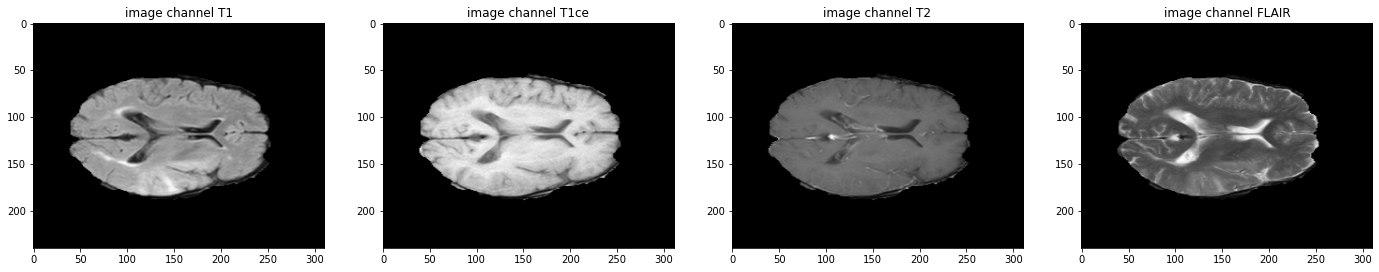

label shape: torch.Size([3, 240, 311, 201])


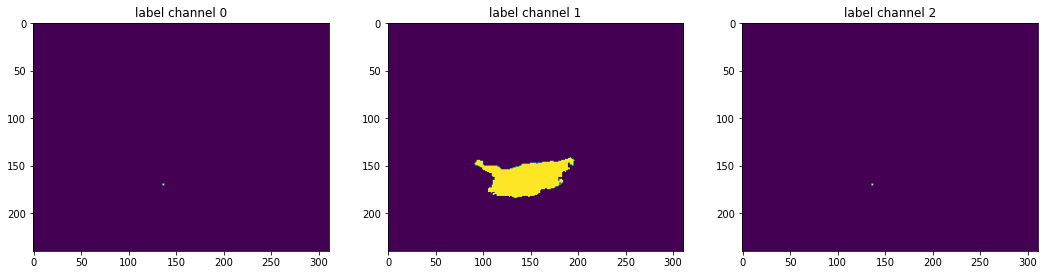

In [8]:
viswiz = Visualizer(4, 3, base_ds[2])
viswiz.plot()


image shape: torch.Size([4, 240, 311, 201])


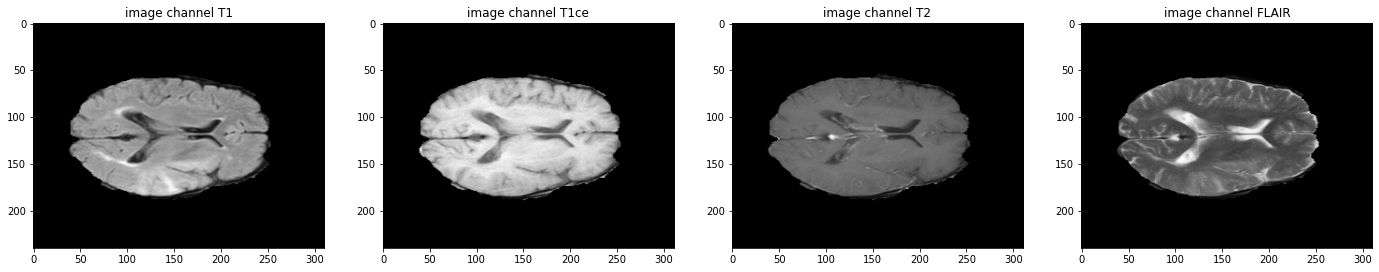

label shape: torch.Size([3, 240, 311, 201])


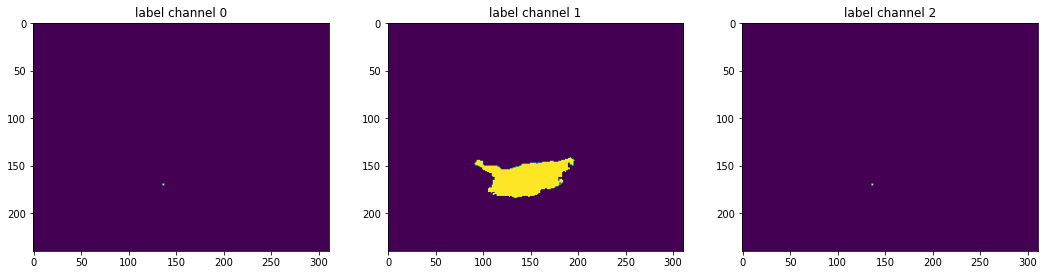

In [9]:
viswiz = Visualizer(4, 3,val_ds[2])
viswiz.plot()